In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yt
from matplotlib.ticker import FuncFormatter

from gallifrey.analysis import bin_planets
from gallifrey.model import Model
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.utilities.math import calculate_pca
from gallifrey.visualization.seaborn_extensions import logyregplot
from gallifrey.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    ridgeplot,
    set_plot_defaults,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-25 18:39:01,646 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-25 18:39:01,799 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-25 18:39:01,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-25 18:39:01,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-25 18:39:01,801 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-25 18:39:01,802 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-25 18:39:01,803 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-25 18:39:01,804 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-25 18:39:01,804 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-25 18:39:01,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-25 18:39:01,807 Parameters: hubble_constant      

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Radial_planet_distribution"
save = True

## CREATE DATASOURCE

In [7]:
radius = 0.2 * mw.virial_radius()

## NORMALISED PROFILES

In [8]:
normalized_profiles, bins = bin_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    bin_field="particle_radius",
    model_config={"ngpps_num_embryos": 50},
    num_bins=200,
    bin_limits=(1, 25),
    log_bins=True,
    density="spherical",
    normalize="first_bin",
    cumulative=False,
    long_format=True,
    value_name="Normalized Density of Planets",
    description={"num_embryos": num_embryos},
)
normalized_profiles, normalized_profiles_label_dict = rename_labels(normalized_profiles)


      TIMER: Block 'Adding Planets...' took 3.13 seconds.



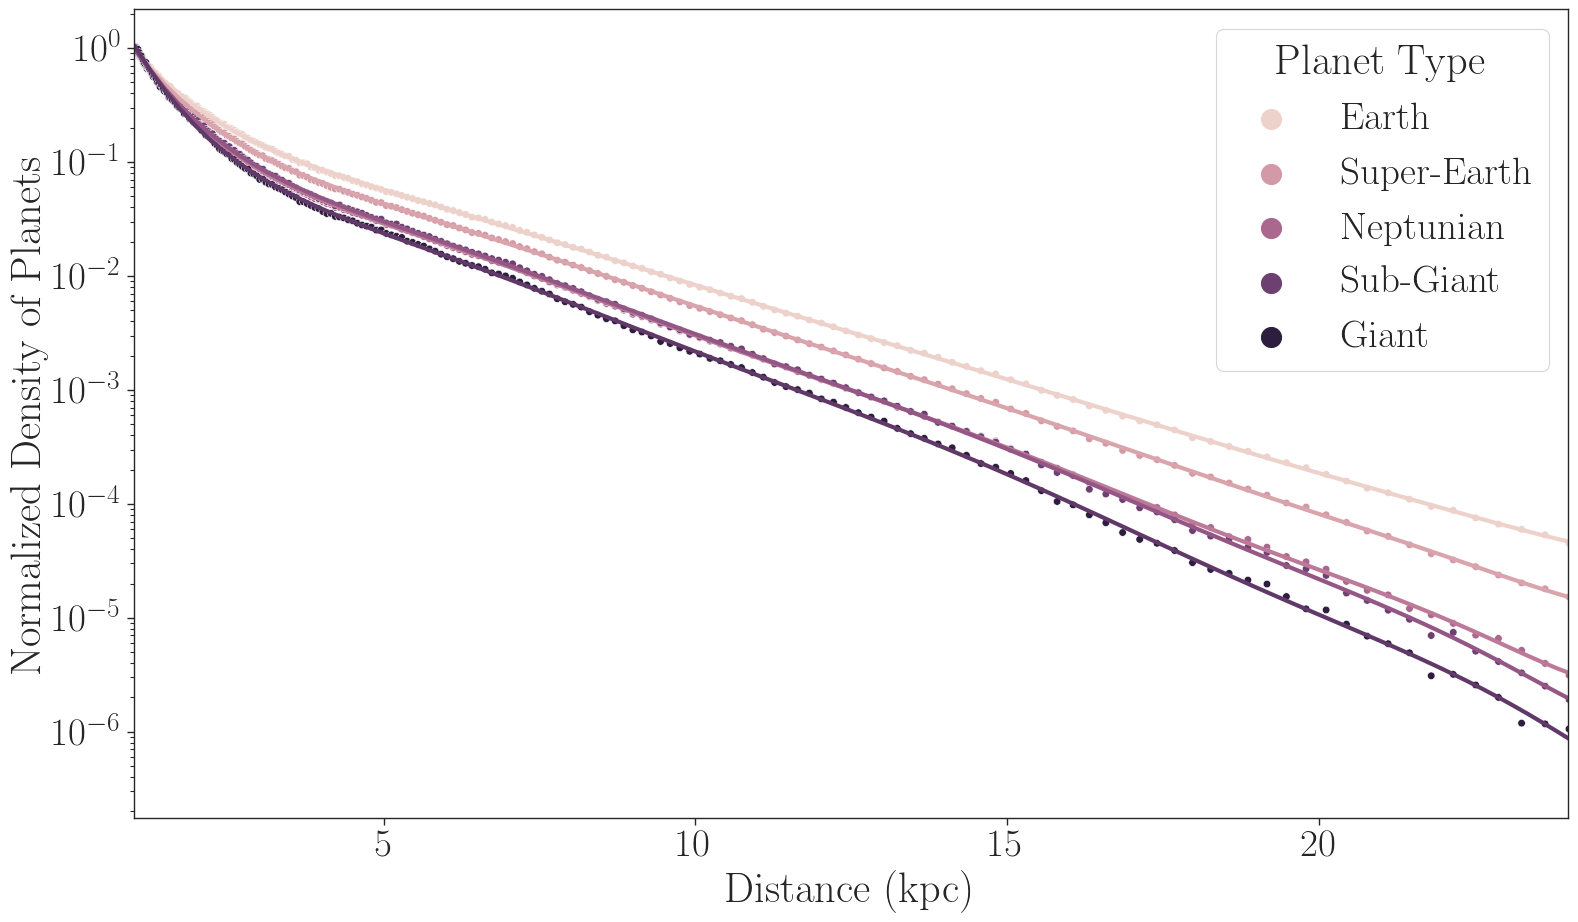

In [9]:
with sns.axes_style("ticks"):
    fig, normalized_plot = plt.subplots()
    for i, planet_type in enumerate(planet_categories):
        logyregplot(
            normalized_profiles[normalized_profiles["Planet Type"] == planet_type],
            x=normalized_profiles_label_dict["particle_radius"],
            y="Normalized Density of Planets",
            color=get_palette()[i],
            scatter=False,
            ci=None,
            line_kws={"linewidth": 3},
            scatter_kws={"s": 0},
            order=9,
            ax=normalized_plot,
        )
    sns.scatterplot(
        normalized_profiles,
        x=normalized_profiles_label_dict["particle_radius"],
        y="Normalized Density of Planets",
        hue="Planet Type",
        palette=get_palette(n_colors=len(planet_categories)),
        s=30,
        ax=normalized_plot,
    )

    normalized_plot.set_xlim(1, 24)
    normalized_plot.legend(markerscale=3, title="Planet Type")
    normalized_plot.set_yscale("log")

FigureProcessor(normalized_plot.figure).save(
    f"normalized_planet_density.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## CUMULATIVE PROFILES

In [10]:
cumulative_profiles, bins = bin_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    bin_field="particle_radius",
    model_config={"ngpps_num_embryos": 50},
    num_bins=200,
    bin_limits=(0.001, 10),
    log_bins=True,
    density=None,
    normalize="area",
    cumulative=True,
    long_format=True,
    value_name="Normalized Cumulative Number of Planet",
    description={"num_embryos": num_embryos},
)
cumulative_profiles, cumulative_profiles_label_dict = rename_labels(cumulative_profiles)


      TIMER: Block 'Adding Planets...' took 3.15 seconds.



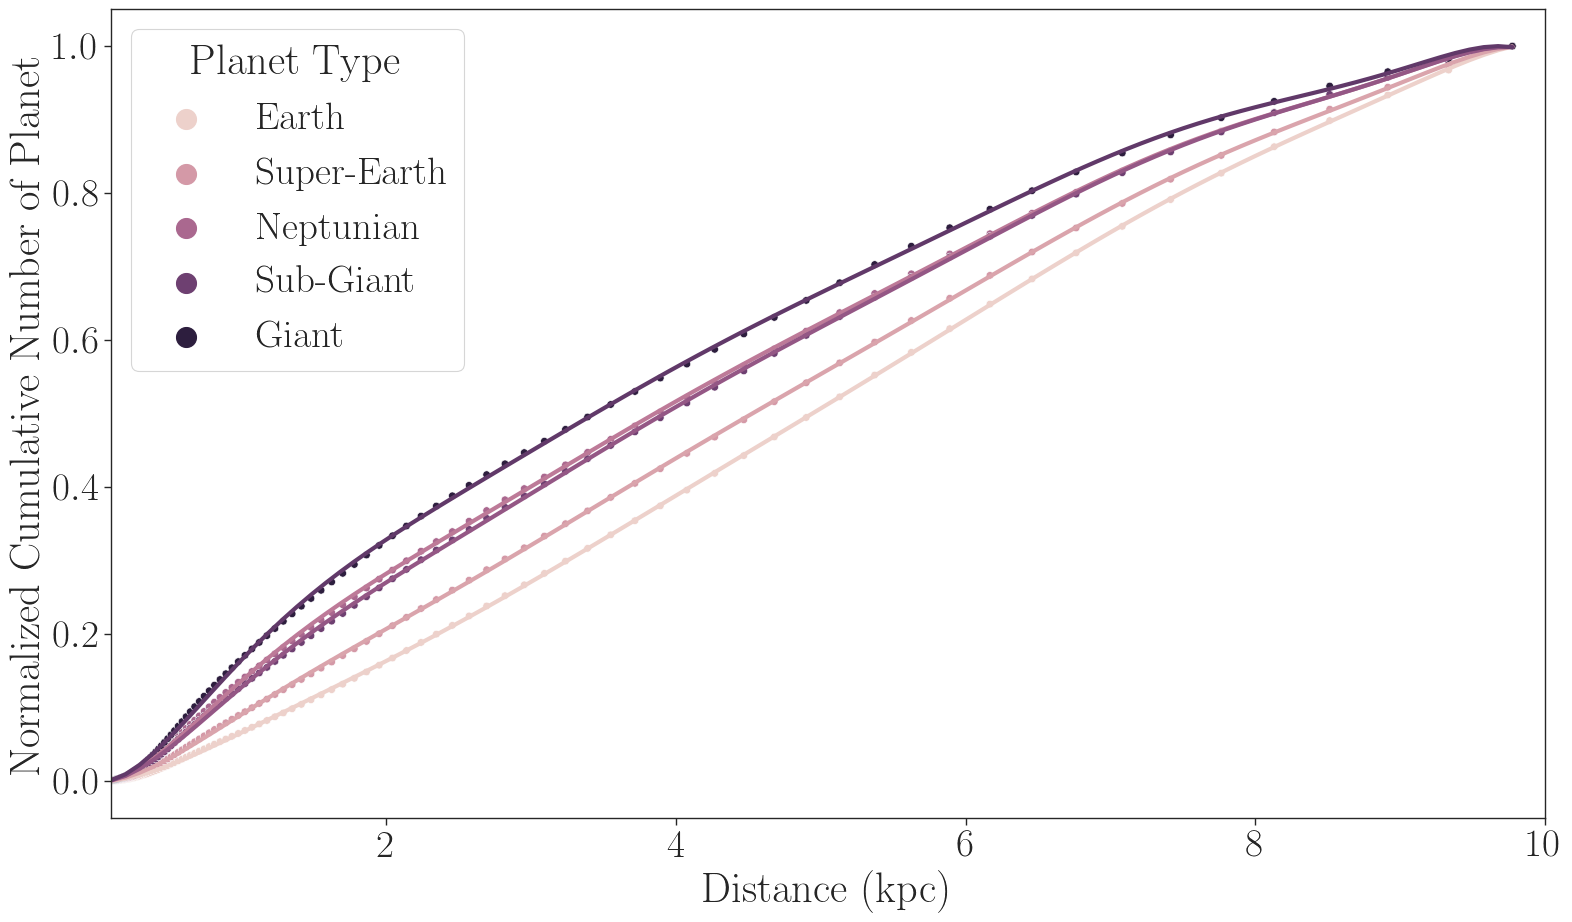

In [11]:
with sns.axes_style("ticks"):
    fig, cumulative_plot = plt.subplots()
    for i, planet_type in enumerate(planet_categories):
        sns.regplot(
            cumulative_profiles[cumulative_profiles["Planet Type"] == planet_type],
            x=cumulative_profiles_label_dict["particle_radius"],
            y="Normalized Cumulative Number of Planet",
            color=get_palette()[i],
            scatter=False,
            ci=None,
            line_kws={"linewidth": 3},
            order=9,
            ax=cumulative_plot,
        )
    sns.scatterplot(
        cumulative_profiles,
        x=cumulative_profiles_label_dict["particle_radius"],
        y="Normalized Cumulative Number of Planet",
        hue="Planet Type",
        palette=get_palette(n_colors=len(planet_categories)),
        s=30,
        ax=cumulative_plot,
    )

    cumulative_plot.set_xlim(0.1, 10)
    cumulative_plot.legend(markerscale=3, title="Planet Type")

FigureProcessor(cumulative_plot.figure).save(
    f"cumulative_planet_distribution.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## EMBRYO NUMBER EFFECT

In [12]:
planet_profiles = []
for num_embryos in [10, 20, 50, 100]:
    profiles, bins = bin_planets(
        model,
        lambda: mw.sphere(radius=radius),
        planet_categories,
        bin_field="particle_radius",
        model_config={"ngpps_num_embryos": num_embryos},
        num_bins=30,
        bin_limits=(1, 25),
        log_bins=True,
        density="spherical",
        long_format=True,
        value_name=r"Density of Planets (1/kpc$^3$)",
        description={"num_embryos": num_embryos},
    )
    planet_profiles.append(profiles)
planet_profiles = pd.concat(planet_profiles)
planet_profiles, planet_profiles_label_dict = rename_labels(planet_profiles)


      CONFIG: Setting ngpps_num_embryos to 10.




      TIMER: Block 'Adding Planets...' took 1.9 seconds.



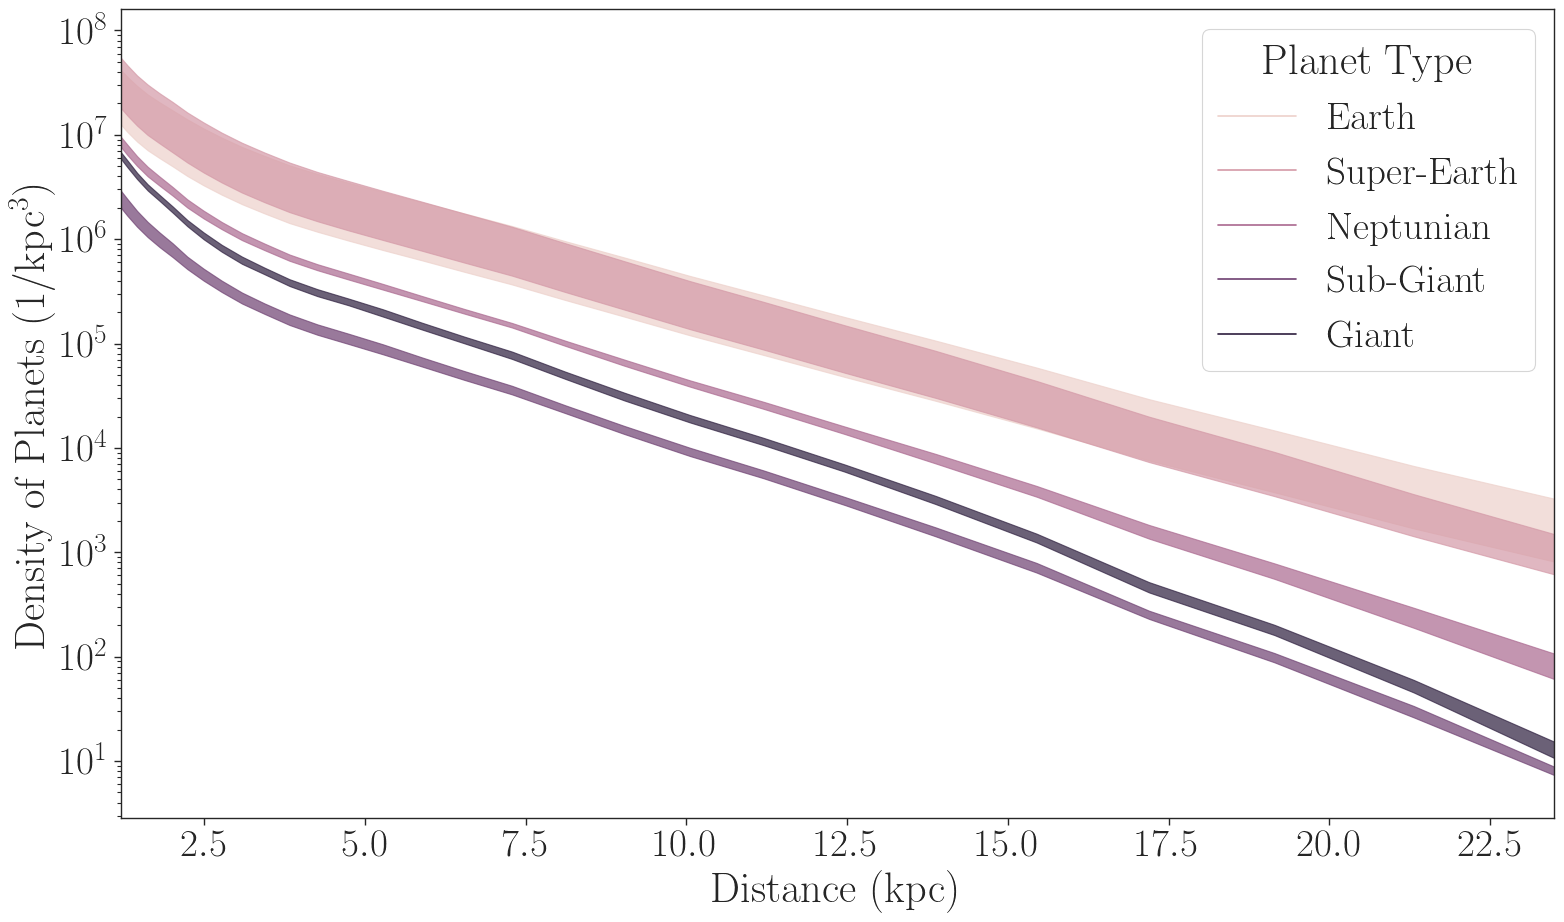

In [ ]:
with sns.axes_style("ticks"):
    profile_plot = sns.lineplot(
        planet_profiles,
        x=planet_profiles_label_dict["particle_radius"],
        y="Density of Planets (1/kpc$^3$)",
        hue="Planet Type",
        errorbar=("pi", 100),
        palette=get_palette(n_colors=len(planet_categories)),
        alpha=0,
        err_kws={"alpha": 0.7},
    )
    profile_plot.set_xlim(1.2, 23.5)
    profile_plot.set_yscale("log")